<a href="https://colab.research.google.com/github/jeffbgreene/geology-558/blob/main/Unsupervised_Learning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning focused on dimensionality reduction using Asterank asteroid data
#### Jeff Greene
#### 1/25/2025


In [1]:
# Install the requests library so that the API call to Asterank can be made
!pip install requests
!pip install umap-learn

In [2]:
import pandas as pd
import numpy as np

# For PCA
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA

# For UMAP
import umap

# For t-SNE
from sklearn.manifold import TSNE

# KMeans to cluster embeddings before using silhouette_score
from sklearn.cluster import KMeans

# Metric used for scoring the differnt algorithms
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Libraries for API call and JSON parsing
import requests
from pandas import json_normalize

# Set the figure size
plt.rcParams["figure.figsize"] = (25,25)
# Set the default font size
plt.rcParams.update({'font.size': 15})

## Background on the dataset

---



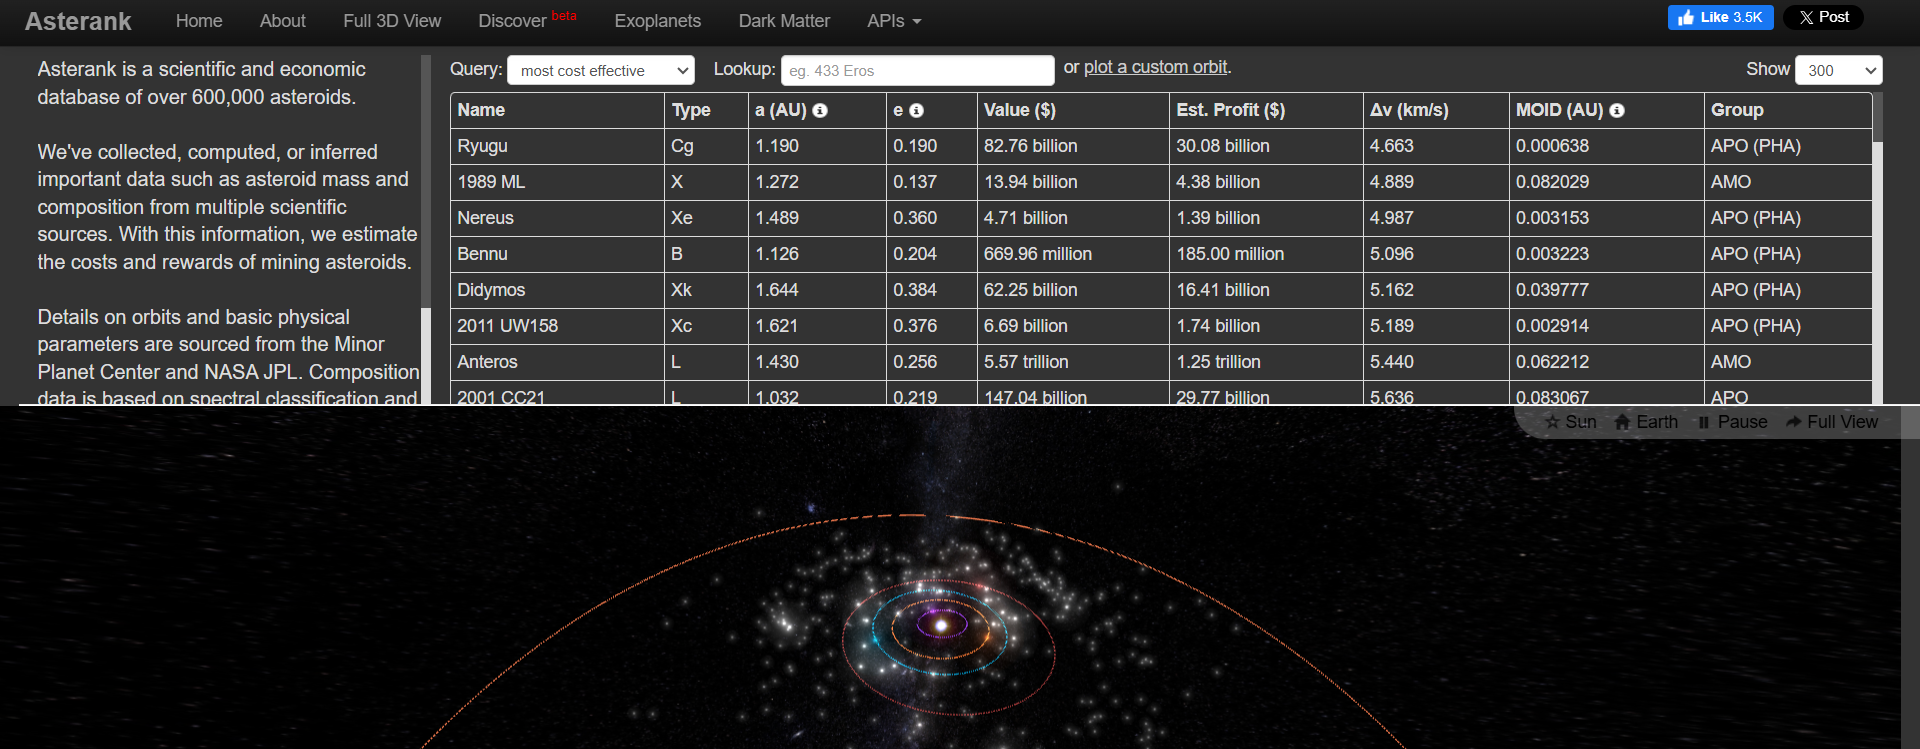

  *Figure 1: Screen capture of the Asterank website*




### Data for this project was retrieved from Asterank, "a scientific and economic database of over 600,000 asteroids". Asteroid data sorted by valuation from the Asterank API.

### The **goal** of this project was to determine if the data set features could be be reduced from a high-dimension feature space to a low-dimension feature space while preventing loss of important information about the data set using PCA, UMAP and t-SNE.

### **Improvements** to this notebook included a bit more Markdown explaining the data and process, inclusion of the Pearson Correlation matrix that was in the EDA and the use of the `silhouette score` as mentioned in the peer review feedback. I also used the results from PCA to feed into the t-SNE algorithm.

### I do have concerns with including `silhouette score` for scoring dimensionality reduction, as my understanding is that this metric measures how well a clustering algorithm groups data points. To account for this, I clustered the results from each technique before applying the `silhouette score`. I did not see very good results from the silhouette scores for PCA, but did see better results for UMAP and t-SNE. Nonetheless, the high `trustworthiness` scores lead me to believe that the algorithms are all doing a "good" job of translating the data from a high-dimension to low-dimension with minimal loss, which as stated above, was my goal.

### Below is a table of some of the features that are in the data set and the description of what they are.

*Tabel 1: Attributes of the Asterank dataset*


| Attributes | Description |
| ---- | ---- |
| SPK-ID | Object primary SPK-ID |
| ID | Object internal database ID |
| Fullname | Object full name/designation |
| pdes | Object primary designation |
| NEO | Near-Earth Object (NEO) flag |
| PHA | Potentially Hazardous Asteroid (PHA) flag |
| H | Absolute magnitude parameter |
| Diameter | object diameter (from equivalent sphere) km Unit |
| Albedo | Geometric albedo |
| Diameter sigma | 1-sigma uncertainty in object diameter km Unit |
| Orbit id | Orbit solution ID |
| Epoch | Epoch of osculation in modified Julian day form |
| Equinox | Equinox of reference frame |
| e | Eccentricity |
| a | Semi-major axis au Unit |
| q | perihelion distance au Unit |
| i | inclination; angle with respect to x-y ecliptic plane |
| tp | Time of perihelion passage TDB Unit |
| moid ld | Earth Minimum Orbit Intersection Distance au Unit |

## Data set retrival and cleaning

---

I retrieved 5000 rows sorted by the asteroid valuation. According to Asterank, "Value estimates are based on the mass of a given asteroid and its spectral type. Asteroid spectra is used to infer composition, which, in conjunction with current market prices, determine potential value." [1]

This valuations are approximations and should not be considered as truthful values, as most likely these are "in-place" values, not accounting for the cost to travel to the asteroid, extract the material, return it to a processing location, and then treat, store and transport the materials for sale.

Although this unit is focused on unsupervised learning, I did extract a couple of features that could be utilized as labels and help determine the performance of the dimensionality reduction algorithms. These columns are potentially hazardous asteroids (PHA) and classification, which refers to the asteroids location in our solar system.

As far as data cleaning, I only kept columns with more than 4000 non-NAN values, dropped the SPK-ID and seperated out the PHA and Class columns. I then numerically encoded the PHA column to be a 1 for yes and 0 for no and used the Scikit Learn label encoder to numerically encode the Class column values. These updated coulmns replaced their counterparts in the dataframe. Finally, I dropped any columns that were listed as an object type (strings that can't be used in any of the unsupervised algorithms), and dropped rows with NAN values. This left me with 4,612 samples to use dimenstionality reduction.

For more in-depth knowledge of the EDA behind the dataset, please see the Unsupervised EDA notebook in this repo: https://github.com/jeffbgreene/geology-558/blob/main/Unsupervised_EDA.ipynb

In [3]:
# Using an API call to Asterank to get the first 5000 rows of data sorted by asteroid value
url = 'https://www.asterank.com/api/rankings?sort_by=value&limit=5000'
data = requests.get(url)

# Store the API response in a variable.
available_data = data.json()
df = json_normalize(available_data)
print(f'The length of the Asterank dataset for the unsupervised module is: {len(df)}')

The length of the Asterank dataset for the unsupervised module is: 5000


In [4]:
# Only keep colunns with 4000 or more non-NAN values
df.dropna(thresh=4000, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 56 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sigma_tp        4874 non-null   float64
 1   epoch_mjd       5000 non-null   float64
 2   ad              5000 non-null   float64
 3   producer        5000 non-null   object 
 4   rms             5000 non-null   float64
 5   closeness       5000 non-null   float64
 6   prov_des        4743 non-null   object 
 7   tp              5000 non-null   float64
 8   full_name       5000 non-null   object 
 9   sigma_per       4874 non-null   float64
 10  equinox         5000 non-null   object 
 11  sigma_ad        4874 non-null   float64
 12  saved           5000 non-null   float64
 13  moid_ld         4997 non-null   float64
 14  neo             5000 non-null   object 
 15  profit          5000 non-null   float64
 16  spkid           5000 non-null   float64
 17  sigma_w         4874 non-null   f

In [5]:
df.head()

,sigma_tp,epoch_mjd,ad,producer,rms,closeness,prov_des,tp,full_name,sigma_per,...,om,e,i,spec,q,moid_jup,w,sigma_ma,dv,sigma_q
0,0.000050,58600.0,3.760305,Otto Matic,0.49535,2634.479570,1903 LU,2.458749e+06,511 Davida (1903 LU),0.000008,...,107.596326,0.188135,15.938225,C,2.569456,1.47719,337.440540,0.000009,11.144603,9.266100e-08
1,0.000720,58600.0,3.981728,Otto Matic,0.48923,2622.635949,1892 L,2.459550e+06,334 Chicago (1892 L),0.000029,...,130.163228,0.023502,4.643112,C,3.798870,1.07555,148.771059,0.000092,11.703702,1.808900e-07
2,0.000576,58600.0,3.247375,Otto Matic,0.44762,2631.736774,1910 KQ,2.458288e+06,702 Alauda (1910 KQ),0.000014,...,289.745523,0.017244,20.602228,B,3.137278,1.94887,350.767999,0.000100,12.757615,1.153300e-07
3,0.000289,58600.0,3.176470,Otto Matic,0.44609,2634.754684,1896 DB,2.458261e+06,423 Diotima (1896 DB),0.000008,...,69.374213,0.035882,11.244266,C,2.956412,1.85955,198.548794,0.000053,11.224330,1.117100e-07
4,0.000053,58600.0,3.966001,Otto Matic,0.49557,2635.271820,1893 AH,2.458078e+06,372 Palma (1893 AH),0.000009,...,327.356998,0.258992,23.825957,B,2.334280,1.57726,115.574876,0.000009,11.987880,1.189500e-07


In [6]:
df['class'].unique()
classes = ['MBA', 'OMB', 'CEN', 'TJN', 'MCA', 'APO', 'AMO', 'IMB', 'ATE',
       'TNO', 'IEO']

In [7]:
# Convert PHA label to numeric values
from sklearn.preprocessing import LabelEncoder

# Instantiate a LabelEncoder object
le = LabelEncoder()

# Grab all values of the 'class' feature
strings = df[['class']]
# Fit the LabelEncoder to the data
le.fit(np.ravel(strings))
# Convert the string values to integers
integers = le.transform(np.ravel(strings))
# Replace the class feature with the integer mapping value
df['class'] = integers

# Map PHA to a binary, integer value
df['pha'] = df['pha'].replace({'Y': 1, 'N': 0})

<ipython-input-7-f22f187912ee>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pha'] = df['pha'].replace({'Y': 1, 'N': 0})


In [8]:
# Keep only the columns that are numerical values (float64)
df_numeric = df.select_dtypes(exclude='object')
df_numeric.drop('spkid', axis=1, inplace=True)
df_numeric.shape

(5000, 43)

In [9]:
# Drop all the rows with NAN values for any column
df_numeric.dropna(inplace=True)

# Pull out the Labels (PHA) for use in UMAP
y_asteroid_class = df_numeric[["class"]].values.flatten()
y_pha = df_numeric[["pha"]].values.flatten()

df_numeric.drop(["pha", "class"], axis=1, inplace=True)

df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4612 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sigma_tp    4612 non-null   float64
 1   epoch_mjd   4612 non-null   float64
 2   ad          4612 non-null   float64
 3   rms         4612 non-null   float64
 4   closeness   4612 non-null   float64
 5   tp          4612 non-null   float64
 6   sigma_per   4612 non-null   float64
 7   sigma_ad    4612 non-null   float64
 8   saved       4612 non-null   float64
 9   moid_ld     4612 non-null   float64
 10  profit      4612 non-null   float64
 11  sigma_w     4612 non-null   float64
 12  epoch       4612 non-null   float64
 13  per         4612 non-null   float64
 14  data_arc    4612 non-null   float64
 15  sigma_i     4612 non-null   float64
 16  score       4612 non-null   float64
 17  per_y       4612 non-null   float64
 18  sigma_n     4612 non-null   float64
 19  epoch_cal   4612 non-null   floa

# PCA Dimensionality Reduction

## Standardizing the data

---


#### As it is a good practice, I standardized the data just using the Scikit Learn StandardScaler class on the feature set

In [10]:
#Standardize the features
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df_numeric)) #scaling the data

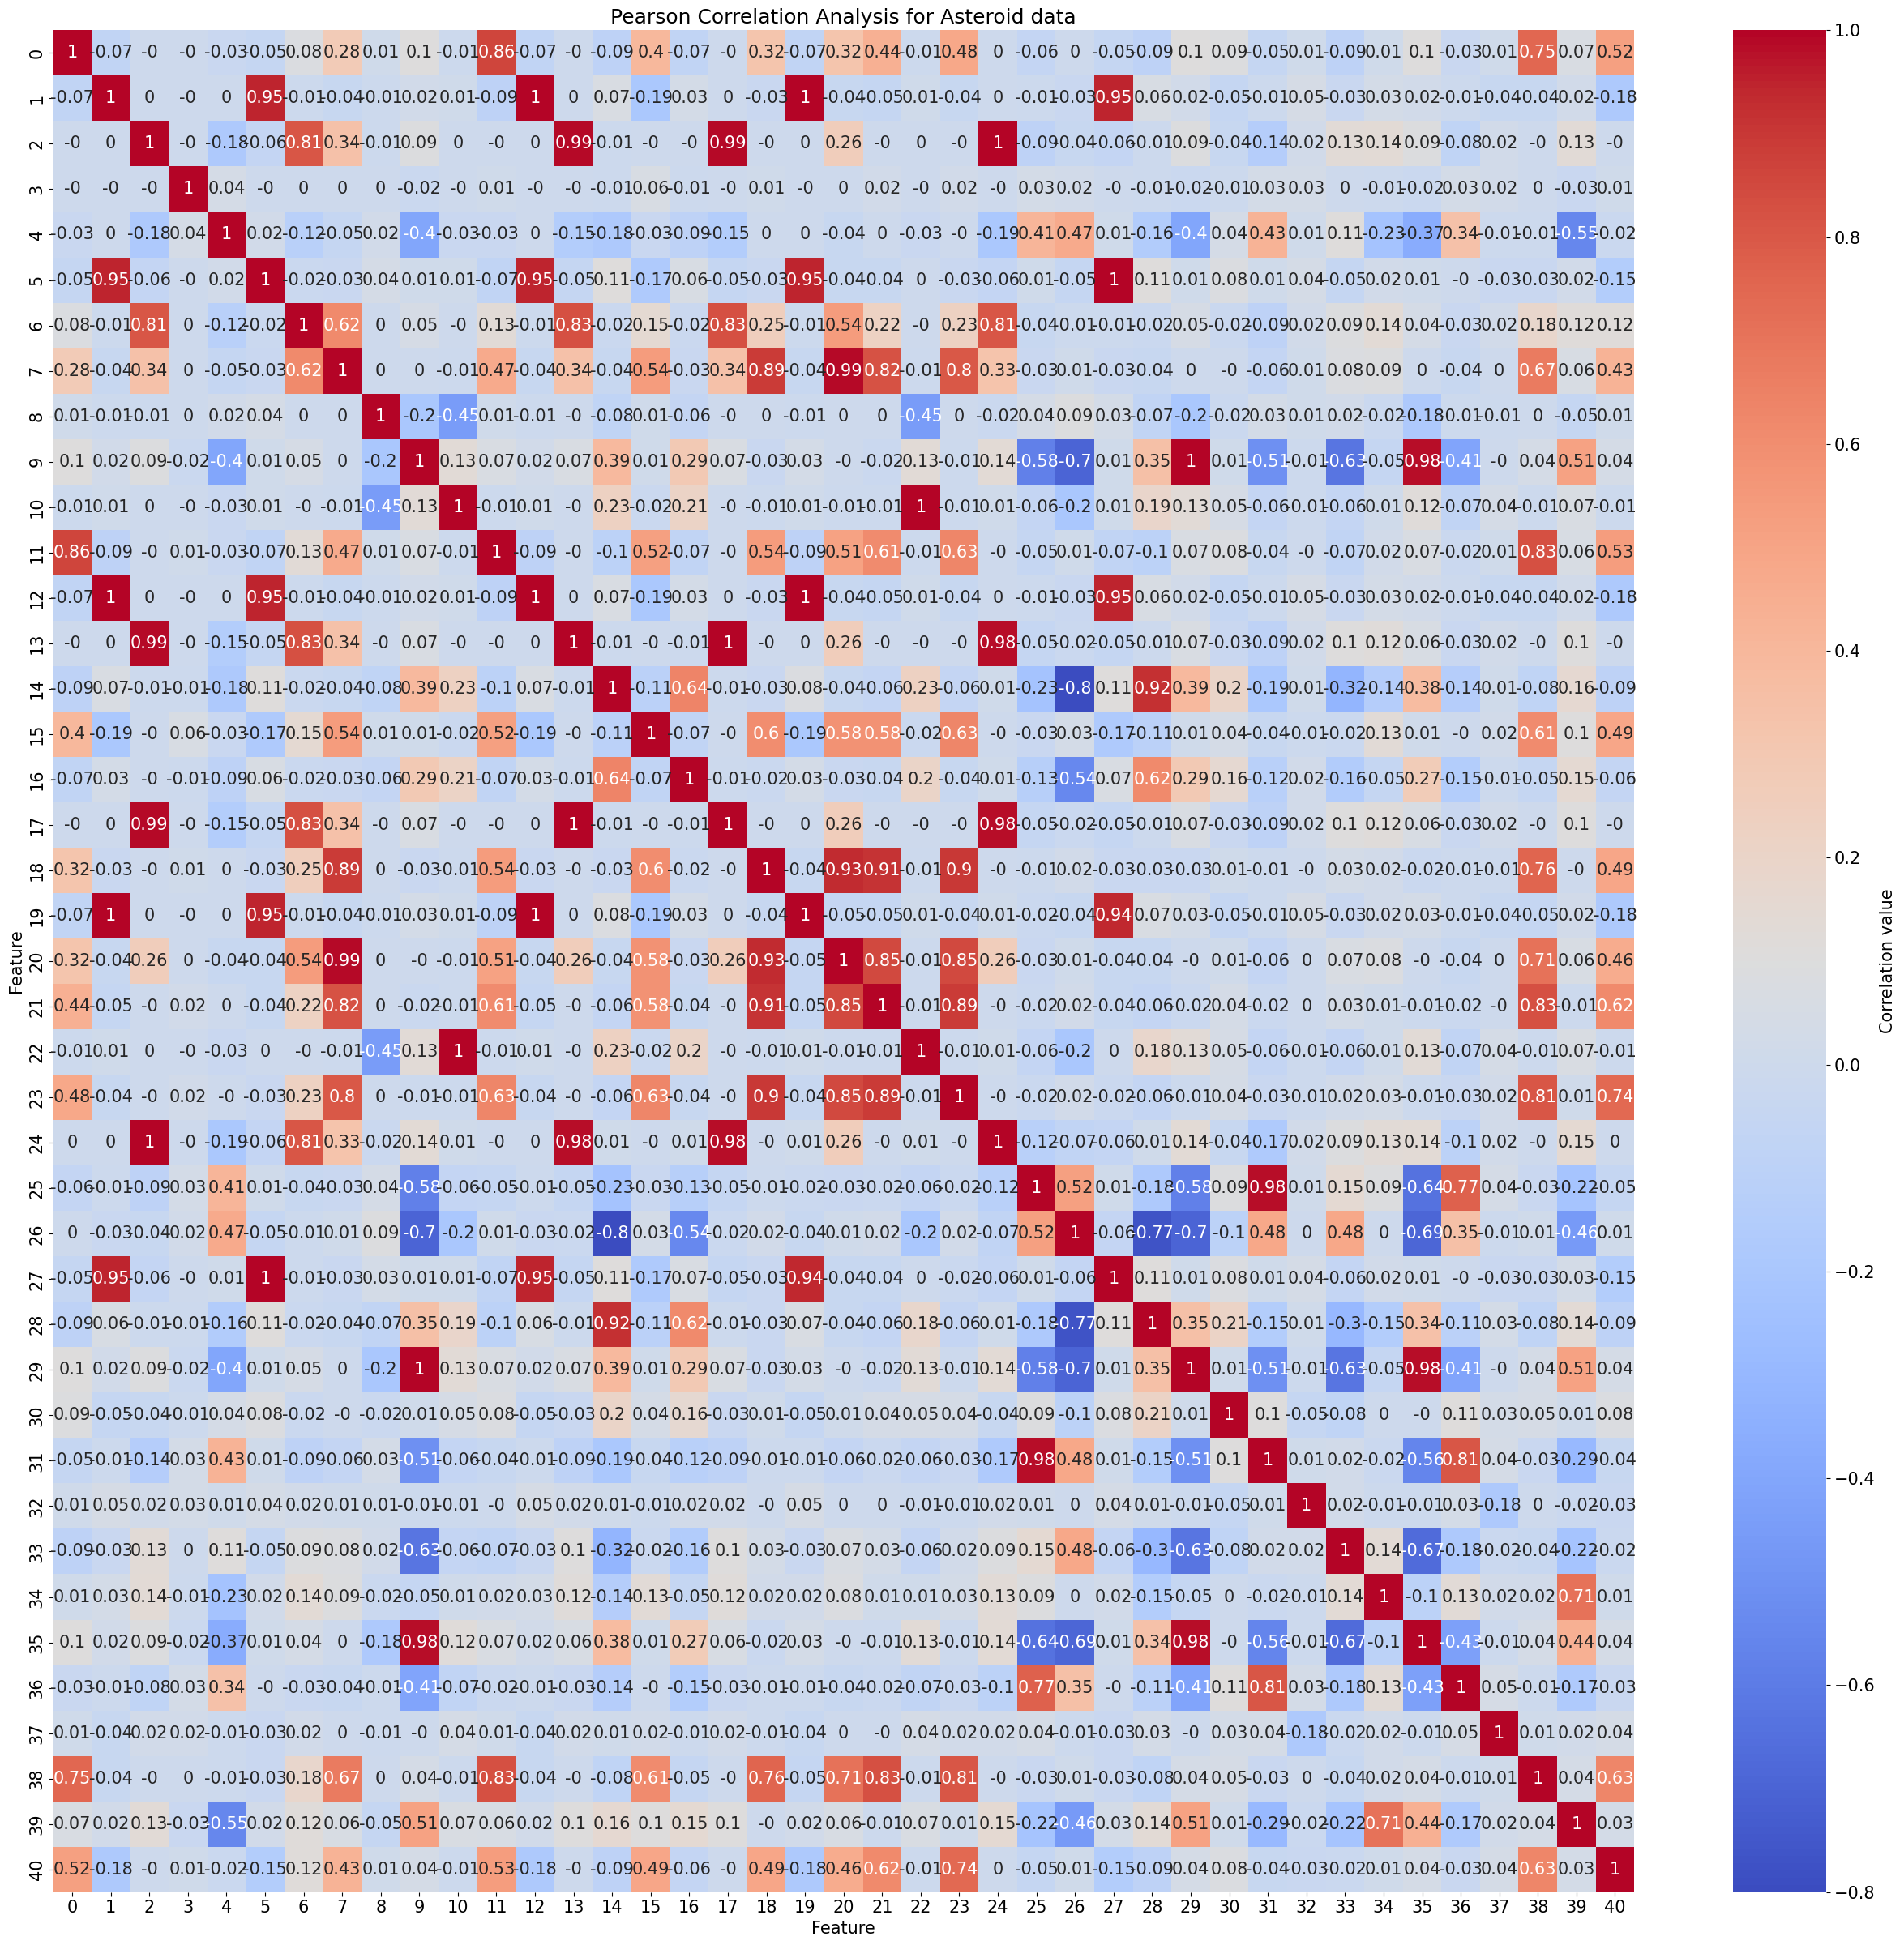

In [11]:
fig, ax = plt.subplots(sharex=True)

# Calculate the correlation matrix, dropping all NaN rows and columns
correlation_matrix = scaled_data.corr(method='pearson').dropna(axis=0, how='all').dropna(axis=1, how='all').round(2)

# Plot the results of the correlation as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation value'})
plt.title("Pearson Correlation Analysis for Asteroid data")
plt.ylabel('Feature')
plt.xlabel('Feature')
ax.set_position([0.55, 0.1, 0.35, 0.8])  # Adjust position manually

plt.tight_layout()
plt.show()

*Figure 2: Pearson Correlation Matrix of 41 remaining features in the dataset*

### **Create a Scree plot to determine the proper number of components**

---

#### Research has shown that one way of properly determining the `n_components` hyperparameter for the PCA algorithm is to visualize the data using a Scree plot, which can be seen in Figure 3. Essentially it shows the eigenvalues for each individual principle component. All features are used then the PCA model is fit to the data. The explained variance of the resulting model (the eigenvalues) are then plotted on the y-axis and the number of features on the x-axis.
#### An interesting geology note, according to Sanchita Managale, contributor to an article on the website Medium,  "In the PCA literature, the plot is called a ‘Scree’ Plot because it often looks like a ‘scree’ slope, where rocks have fallen down and accumulated on the side of a mountain."[2]

#### I also assessed the variance to determine that the selected number of PC's described 80% of the variance. As can be seen in Figure 4, the selection of 10 PC's descibes 80% of the variance.

In [12]:
covariance_matrix = PCA(n_components = len(scaled_data.columns))
covariance_matrix.fit(scaled_data)

PCA(n_components=41)

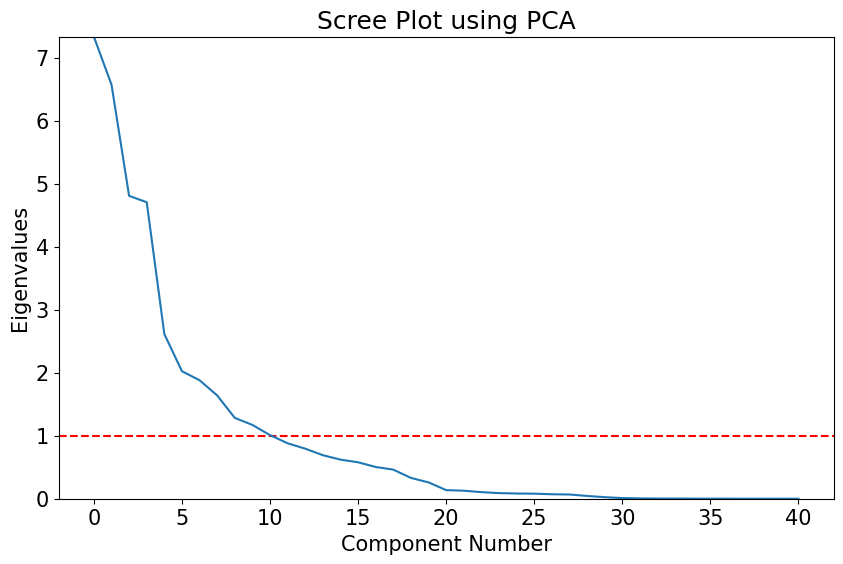

In [13]:
plt.figure(figsize=(10,6))
plt.ylabel('Eigenvalues')
plt.xlabel('Component Number')
plt.title('Scree Plot using PCA')
plt.ylim(0,max(covariance_matrix.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y=1, color='r', linestyle='--')
plt.plot(covariance_matrix.explained_variance_)
plt.show()

<center><i>Figure 3: Scree plot to determine the proper number of components. Using the Kaiser rule, I picked the number of components where the eignevalues equaled 1</i></center>

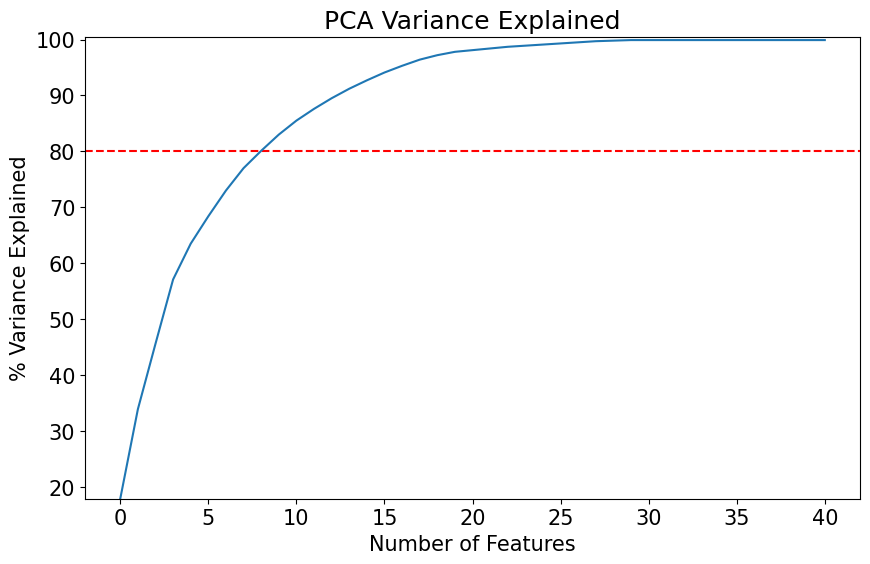

In [14]:
variance = covariance_matrix.explained_variance_ratio_
var=np.cumsum(np.round(covariance_matrix.explained_variance_ratio_, decimals=3)*100)

plt.figure(figsize=(10,6))
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Variance Explained')
plt.ylim(min(var), 100.5)
plt.style.context('seaborn-whitegrid')
plt.axhline(y=80, color='r', linestyle='--')
plt.plot(var)
plt.show()

<center><i>Figure 4: Plot of the variance explained ratio, which shows that 80% of the variance is described by 10 PC's.</i></center>

In [15]:
#Applying PCA
#Setting number of Principal Components to 10
%%time
pca = PCA(n_components = 10)
data_pca = pca.fit_transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])

CPU times: user 11.9 ms, sys: 38.5 ms, total: 50.4 ms
Wall time: 10.5 ms


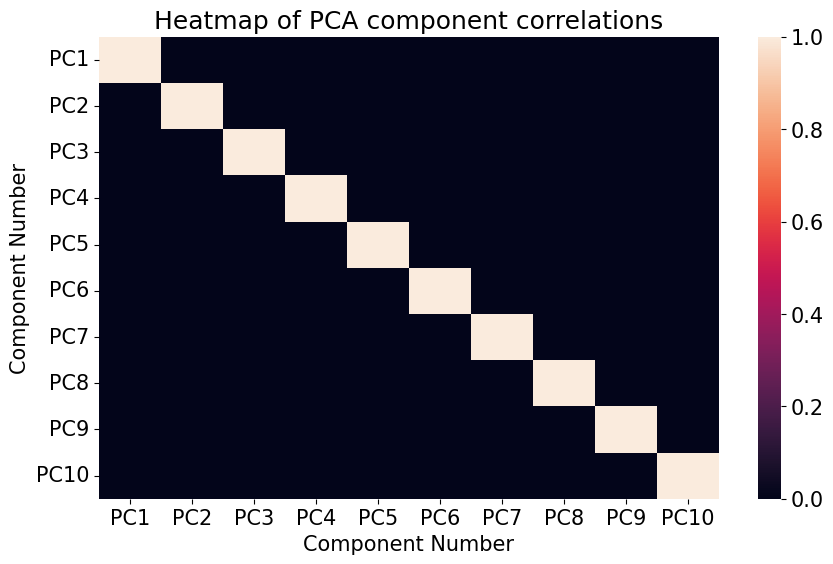

In [16]:
#Checking Correlation between features after PCA
plt.figure(figsize=(10,6))
sns.heatmap(data_pca.corr())
plt.ylabel('Component Number')
plt.xlabel('Component Number')
plt.title('Heatmap of PCA component correlations')
plt.show()

<center><i>Figure 5: Correlation Matrix after applying PCA</i></center>

Utilizing PCA, the data has been mapped from a high-dimensional feature space to a lower-dimensional feature space. Visualizing the results shows that there is no correlation between the principle components. Therefore, I believe I have achevied my goal of reducing the number of features via dimensionality reduction. Just to ensure that the PCA model I have built represents the higher dimensional data, I will run it through the trustworthiness metric.

In [17]:
print(f"{trustworthiness(scaled_data, data_pca, n_neighbors=5):.2f}")

0.99


A very high score of 0.99 indicates that as described in the documentation, "the local structure is retained."[3]

In [18]:
# Perform KMeans clustering on the PCA results
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(data_pca)
# Calculate silhouette score
print(f"Silhouette Score: {silhouette_score(data_pca, labels):.2f}")

Silhouette Score: 0.28


As suggested in the peer review, I also applied the Silhouette Score to the results. Before doing this, I first clustered the data using K-Means. A score of 0.28 is considered a bad fit. However, I am happy with the results as the more significant metric, the trustworthiness score is very high.

Finally, I experimented with plotting the PC's. Plotting PC2 and PC3 doesn't really show clear seperation of clusters, unless you zoom in on them. Even then, there is still a lot of overlap

In [19]:
fig = px.scatter(data_frame=data_pca, x='PC2', y='PC3', color=y_asteroid_class)
fig.update_layout(
    title="PCA visualization of Component 2 and Component 3 for the Asterank Asteroid dataset",
    title_x=0.5,
    xaxis_title="Second Principal Component",
    yaxis_title="Third Principal Component",
)
fig.show()

<center><i>Figure 6: Scatter Plot of PC 2 and 3</i></center>

## Dimensionality reduction with UMAP
I decided to use the same standardized data as for PCA. I plotted the data in a scatterplot and ran the trustworthiness algorithm.

In [20]:
%%time

# Fit UMAP to processed data
embedding = umap.UMAP(n_neighbors=5).fit_transform(scaled_data)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



CPU times: user 29 s, sys: 2.16 s, total: 31.1 s
Wall time: 22.6 s


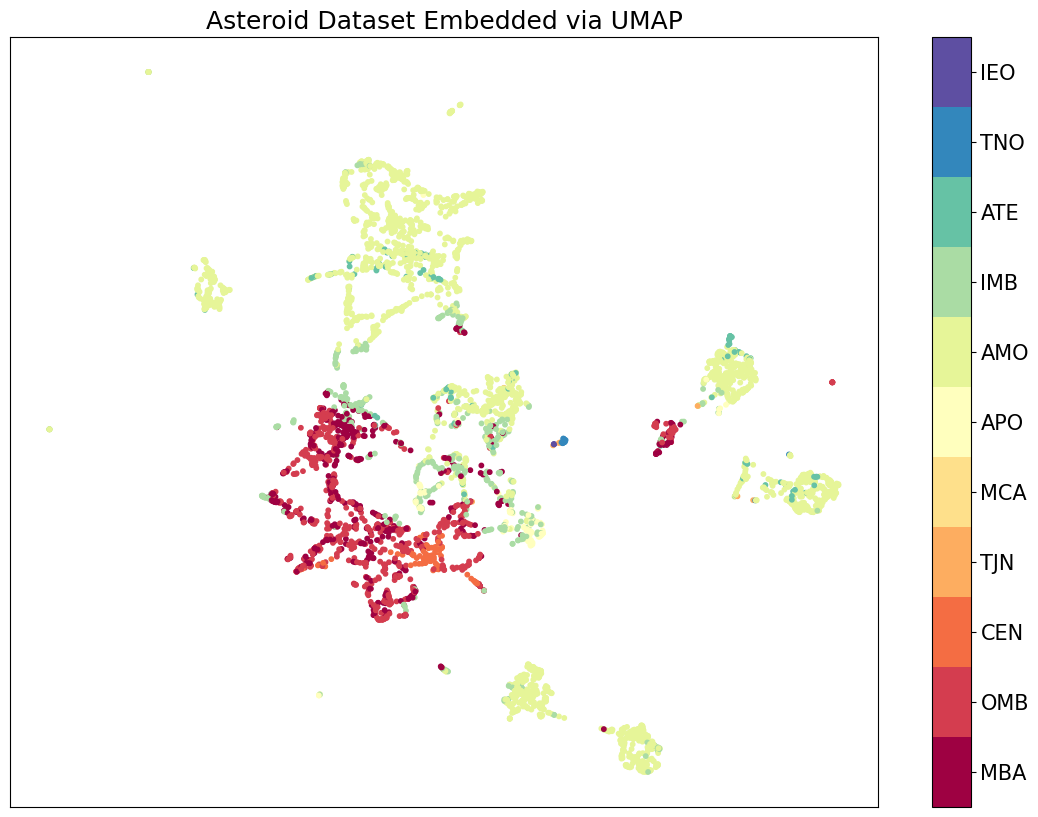

In [21]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=10, c=y_asteroid_class, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(12)-0.5)
cbar.set_ticks(np.arange(11))
cbar.set_ticklabels(classes)
plt.title('Asteroid Dataset Embedded via UMAP');


<center><i>Figure 7: Scatter Plot of the 11 asteroid classifications embedded in a lower dimensionality feature space</i></center>

In [22]:
print(f"Trustworthiness score: {trustworthiness(scaled_data, embedding, n_neighbors=5):.2f}")

Trustworthiness score: 0.99


As described in the previous section focused on PCA, a extremely high trustworthiness score indicates that the was minimal loss by utilizing UMAP to reduce the data to a low-dimesion feature space.

In [23]:
# Perform KMeans clustering on the UMAP embedding
kmeans = KMeans(n_clusters=11, random_state=42)
labels = kmeans.fit_predict(embedding)

# Calculate silhouette score
# Calculate silhouette score
print(f"Silhouette Score: {silhouette_score(embedding, labels):.2f}")

Silhouette Score: 0.51


This silhouette score is much better than the one seen with PCA, as anything above 0.5 is considered a good score.

## Dimensionality Reduction using t-SNE

In [24]:
# This takes a really long time to run (approx 3 mins), even using the GPU, because the algorithm is computationally expensive.
# I also have the perplexity set very high, as this high value was giving better results.
# I'm considereing taking the PCA results and then
# reducing the dimensionality even more by feeding those into the t-SNE algorithm
%%time
tsne = TSNE(n_components=2, perplexity=400, random_state=42)
X_tsne = tsne.fit_transform(scaled_data)


CPU times: user 2min 57s, sys: 11.9 s, total: 3min 9s
Wall time: 51.3 s


After fitting and transforming the scaled data, I show the Kullback-Leibler (KL) divergence between the high and low-dimensional probability distributions. The lower the KL divergence usually is indiactive of "better" results [4]. This value is a little high, indicating that using the transformed t-SNE data would result in a high loss of information. Ideally this value would be closer to 0.

In [25]:
print(f"Kullback-Leibler (KL) divergence score: {tsne.kl_divergence_:.2f}")

Kullback-Leibler (KL) divergence score: 0.64


In [26]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y_asteroid_class)
fig.update_layout(
    title="t-SNE visualization of Asteroid dataset",
    title_x=0.5,
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

<center><i>Figure 8: Scatter Plot of the 11 asteroid classifications embedded in a lower dimensionality feature space looking at the first and second t-SNE components</i></center>

In [27]:
print(f"Trustworthiness score: {trustworthiness(scaled_data, X_tsne, n_neighbors=5):.2f}")

Trustworthiness score: 0.98


Again, there is a very high trustworthiness score for the t-SNE results.

In [28]:
# Perform KMeans clustering on the UMAP embedding
kmeans = KMeans(n_clusters=11, random_state=42)
labels = kmeans.fit_predict(X_tsne)

# Calculate silhouette score
# Calculate silhouette score
print(f"Silhouette Score: {silhouette_score(X_tsne, labels):.2f}")

Silhouette Score: 0.37


Applying the Silhouette score to the t-SNE results give mediocre results.

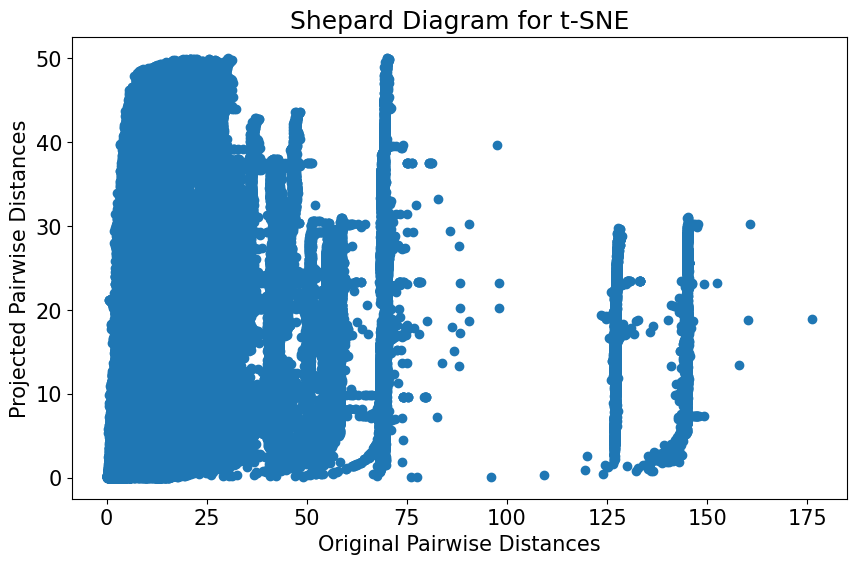

In [29]:
from scipy.spatial.distance import pdist
# Calculate pairwise distances in original data
original_distances = pdist(scaled_data)


# Calculate pairwise distances in t-SNE projected data
projected_distances = pdist(X_tsne)


# Create a Shepard diagram
plt.figure(figsize=(10,6))
plt.scatter(original_distances, projected_distances)
plt.xlabel("Original Pairwise Distances")
plt.ylabel("Projected Pairwise Distances")
plt.title("Shepard Diagram for t-SNE")
plt.show()

<center><i>Figure 9: Shepard Plot of projected pairwise distances compared to the original pairwose distances</i></center>

As a secondary way of visulaizing the t-SNE reults, I plotted a Shepard Diagram. "A Shepard diagram compares how far apart your data points are before and after you transform them (ie: goodness-of-fit) as a scatter plot." [5]

## Applying PCA then t-SNE

---

One final experiment I would like to perform is to see how t-SNE performs by feeding PCA results into the t-SNE algorithm, which was discussed on the website `BuiltIn`.[6]

In [30]:
%%time
tsne = TSNE(n_components=2, perplexity=400, random_state=42)
X_tsne = tsne.fit_transform(data_pca)

CPU times: user 2min 51s, sys: 10.8 s, total: 3min 1s
Wall time: 51.5 s


In [31]:
print(f"Kullback-Leibler (KL) divergence score: {tsne.kl_divergence_:.2f}")

Kullback-Leibler (KL) divergence score: 0.56


In [32]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y_asteroid_class)
fig.update_layout(
    title="t-SNE visualization of Asteroid dataset",
    title_x=0.5,
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

<center><i>Figure 10: Scatter Plot of the 11 asteroid classifications embedded in a lower dimensionality feature space looking at the first and second t-SNE components after applying PCA</i></center>

In [33]:
print(f"Trustworthiness score: {trustworthiness(scaled_data, X_tsne, n_neighbors=5):.2f}")

Trustworthiness score: 0.96


In [34]:
# Perform KMeans clustering on the UMAP embedding
kmeans = KMeans(n_clusters=11, random_state=42)
labels = kmeans.fit_predict(X_tsne)

# Calculate silhouette score
# Calculate silhouette score
print(f"Silhouette Score: {silhouette_score(X_tsne, labels):.2f}")

Silhouette Score: 0.40


As can be seen by the scores above, there was a small improvement in the  Kullback-Leibler (KL) divergence as the score was lowered and an slight increase in the silhouette score.

# Assignment Questions

---


#### **Which method did you like the most?**
Personally, I think I like PCA the most. Using the Scree plot and explained variance to help choose the `n_components` hyperparameter was super straightforward and completely made sense to me. I watch a bunch of videos about the 3 different techniques, and PCA seems to make the most sense to me.
#### **Which method did you like the least?**
I dislike the t-SNE algorithm the least because of the time it took process. Originally, I developed code to loop through different `perplexity` hyperparameter values, but this took an extremely long time.
#### **How did you score these unsupervised models?**
With PCA I used a correlation matrix before and after applying dimensionality reduction. The plots clearly show that there was a high correlation between the high dimensional feature space and no correlation in the lower dimension feature space. I also used the trustworthiness metric, which returned an incredibly high score of 0.98.
For UMAP and t-SNE, I plotted the results on a scatter plot and then color coded them using the asteroid class encoding I derived during preprocessing. I also used the trustworthiness metric for both of these algorithms. For UMAP I saw a score of 0.99 and for t-SNE 0.98.
For all the algorithms, I clustered the results using K-Means and then applied the silhouette score as a second metric for scoring performance.
I applied the Kullback-Leibler (KL) divergence to the t-SNE results. This algorithm is used to compare 2 data distributions. The value of 0.639 indicates that the probability distributions are pretty different, which is not the result I was hoping for when mapping to a lower dimension feature space. I plotted the data out in a Shepard plot to see the relationship between the original data and the reduced data.
I also tried reducing the dimensionality of the data using PCA and then feeding the results into t-SNE as described in an article by Luuk Derksen in BuiltIn. This showed little improvement in the results.
#### **Did the output align with your geologic understanding?**
From the scatter plots, at least the ones for UMAP and t-SNE, I would expect to see clusters formed for each of the asteroid location classes, as some of the features such as the orbital elements will determine that. However, I don't really see clear clusters formed via t-SNE or UMAP. From a dimensionality reduction standpoint, this showed that the feature set could most likely be reduced and then utilized in both supervised and unsupervised algorithms. This means that despite the large number of features for each asteroid, these reduction techniques could be utilized to create lower dimensionality data sets.
#### **What did you want to learn more about?**
From research, it appears that usually PCA is applied first to a data set for reduction and then followed up by t-SNE. I did apply PCA before feeding those results into the t-SNE algorithm as described above. I think the outstanding question I have is what are the optimal hyperparameters. If I had more time would implement hyperparameter tuning using Ray Tune, Determined, or perhaps some other software to try to find the optimal hyperparameters.
#### **Did you pre-process your data?**
I did pre-process my data. I stripped out all string values, except the 2 columns I used as labels, which I encoded. I applied slightly different standardization techniques based off which algorithm I decided to use.
#### **What was a decision you were most unsure about?**
The choice of hyperparameters for UMAP and t-SNE. I tried some different values based off some of the research I did into these algorithms, but it was difficult for me to tell if the choices I was making impacted the performance of the algorithms.


# Conclusion


---

Dimensionality reduction was done on the 41 numeric features remaining in the data set after preprocessing and cleaning. Using applying PCA with 10 principal components, I calculated a 0.99 trustworthiness score. Likewise using UMAP and t-SNE I calculated scores of 0.99 and 0.98 respectively. Based off these metrics I have high confidence that the 3 different models created maintain the structure and connections within the dataset after transforming the data from a high-dimension feature space to a lower-dimension feature space. Future work would involve tuning hyperparameters for both the t-SNE and UMAP algorithms to ensure that the models created are optimized.

# References


---


#### [1] https://www.asterank.com/about
#### [2] https://sanchitamangale12.medium.com/scree-plot-733ed72c8608
#### [3] https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.trustworthiness.html
#### [4] https://medium.com/@hosamedwee/kullback-leibler-kl-divergence-with-examples-part-2-9123bff5dc10#:~:text=The%20KL%20divergence%20can%20then,likely%20doing%20a%20good%20job.
#### [5] https://www.displayr.com/goodness-of-fit-in-mds-and-t-sne-with-shepard-diagrams/
#### [6] https://builtin.com/data-science/tsne-python#:~:text=What%20Is%20a%20T%2DDistributed,embedding%20(t%2DSNE).